# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier, XGBoostClassifier

# Directories

In [24]:
track = 'Long'
particle = 'Electron'

data_path = "/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "/notebooks/mikhail91/PID/mikhail_hushchyn/baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [4]:
data = pandas.read_csv(data_path + "/data_train.csv")

# Features

In [5]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [6]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [7]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [8]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [9]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test = train_test_split(data.index, labels, test_size=0.25, random_state=42)

In [ ]:
%%time
clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=3, 
                        subsample=0.5, 
                        max_depth=8, 
                        features=features)

clf.fit(data.loc[train_inds], labels_train)

# Save the classifier

In [12]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [25]:
new_work_path = work_path + "/" + params_str
new_work_path

'/notebooks/mikhail91/PID/mikhail_hushchyn/baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=1.0;colsample=0.7;max_depth=8;gamma=None;nthreads=3;'

In [26]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

# clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
# pickle.dump(clf, clf_pickle)
# clf_pickle.close()

In [27]:
# Read classifier
clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
clf2 = pickle.load(clf_pickle2)
clf_pickle2.close()

# Test the classifier

In [15]:
probas = clf.predict_proba(data.loc[test_inds])

In [36]:
probas[:5, :]

array([[  6.19318662e-03,   1.60048177e-04,   3.44873726e-04,
          9.92691457e-01,   3.74219642e-04,   2.36278851e-04],
       [  1.32561633e-02,   9.47231718e-04,   1.57549873e-03,
          2.68549293e-01,   4.79173183e-01,   2.36498609e-01],
       [  3.76844476e-03,   1.27728839e-04,   2.22746894e-04,
          9.95522022e-01,   2.03908334e-04,   1.55136528e-04],
       [  1.12106368e-01,   6.31025881e-02,   8.73949286e-03,
          7.73357451e-01,   2.93278433e-02,   1.33662922e-02],
       [  2.11505860e-01,   9.60966863e-04,   6.67705107e-03,
          7.75573850e-01,   3.03174858e-03,   2.25054449e-03]], dtype=float32)

In [31]:
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

def get_roc_curves(probas, labels, particles, colors, labs):

    plt.figure(figsize=(10,7))

    for num in range(0, len(particles)):
        
        one_particle = particles[num]
        one_color = colors[num]
        one_lab = labs[num]

        one_labels = (labels == one_lab)*1
        one_probas = probas[:, num]
        roc_auc = roc_auc_score(one_labels, one_probas)
        fpr, tpr, _ = roc_curve(one_labels, one_probas)
        plt.plot(fpr, tpr, label=one_particle + ', %.2f' % roc_auc, color=one_color, linewidth=2)

    plt.title("ROC AUC", size=15)
    plt.xlabel("FPR", size=15)
    plt.ylabel("TPR", size=15)
    plt.legend(loc='best',prop={'size':15})
    plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.show()

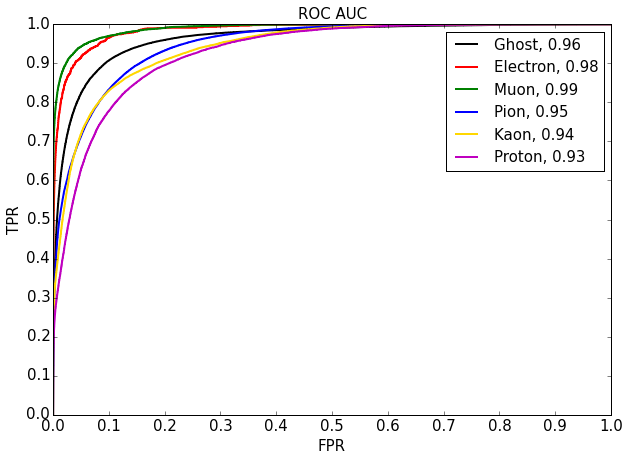

In [38]:
get_roc_curves(probas, labels_test, particles, colors, labs)